## ReMKiT1D input generator - 2-fluid model with effective sources

This notebook shows a simple 2-fluid model example with effective sources corresponding to ionization near the target.


The following are dependencies for this example

In [9]:
import numpy as np
import xarray as xr
import sys

import holoviews as hv
import matplotlib.pyplot as plt
import matplotlib as mpl
from holoviews import opts
import panel as pn

sys.path.append('../')
import RMK_support.simple_containers as sc
import RMK_support.common_models as cm 
import RMK_support.IO_support as io
from RMK_support import RKWrapper ,Grid
import RMK_support.sk_normalization as skn

### Some useful constants

In [10]:
elCharge = 1.60218e-19
elMass = 9.10938e-31
amu = 1.6605390666e-27  # atomic mass unit
ionMass = 2.014*amu  # deuterium mass
epsilon0 = 8.854188e-12  # vacuum permittivity
heavySpeciesMass = 2.014  # in amus


### Wrapper initialization

In [11]:
rk = RKWrapper()


### Global parameters for IO files

In [12]:
rk.jsonFilepath = "./config.json"  # Default value
hdf5Filepath = "./RMKOutput/RMK_simple_fluid/"
rk.setHDF5Path(hdf5Filepath)


### Setting options for external libraries used by ReMKiT1D

#### MPI


In [13]:
numProcsX =16  # Number of processes in x direction
numProcsH = 1  # Number of processes in harmonic
numProcs = numProcsX * numProcsH
haloWidth = 1  # Halo width in cells

rk.setMPIData(numProcsX, numProcsH, haloWidth)


### Normalization

In [14]:
rk.setNormDensity(1.0e19)
rk.setNormTemperature(10.0)
rk.setNormRefZ(1.0)

# for convenience
tempNorm = rk.normalization["eVTemperature"]
densNorm = rk.normalization["density"]

norms = skn.calculateNorms(tempNorm,densNorm,1.0)

timeNorm = norms["time"]
sigmaNorm = norms["crossSection"]
lengthNorm = norms["length"]
speedNorm = norms["speed"]


### Grid initialization

In [15]:
dx0 = 2*0.27/4
dxN = 2*0.0125/4
Nx = 64*4
L = 10 # Length in meters
xGridWidths = L/Nx*np.ones(Nx)
dv0 = 0.05
dvN = 0.4
Nv = 80
vGridWidths = np.geomspace(dv0, dvN, Nv)
lMax = 0
gridObj = Grid(xGridWidths, vGridWidths, lMax, interpretXGridAsWidths=True,
               interpretVGridAsWidths=True, isLengthInMeters=True)


In [16]:
# Add the grid to the config file
rk.grid = gridObj


### Handling particle species data

In [17]:
rk.addSpecies("e", 0, atomicA=elMass/amu, charge=-1.0, associatedVars=["ne", "Ge", "We"])
rk.addSpecies("D+", -1, atomicA=2.014, charge=1.0, associatedVars=["ni", "Gi", "Wi"])

electronSpecies = rk.getSpecies("e")
ionSpecies = rk.getSpecies("D+")


### Custom extrapolation derivs

In [18]:
rk.addCustomDerivation("linExtrapRight",sc.boundedExtrapolationDerivation(sc.linExtrapolation(),ignoreUpperBound=True))

rk.addCustomDerivation("linExtrapRightLB",sc.boundedExtrapolationDerivation(sc.linExtrapolation(),expectLowerBoundVar=True,ignoreUpperBound=True))

rk.addCustomDerivation("boundaryFlux",sc.multiplicativeDerivation("linExtrapRight",innerDerivationIndices=[1],outerDerivation="linExtrapRightLB",outerDerivationIndices=[2,3]))


#### Handling variables 

In [19]:
# Two-point model initialization

Tu = 20/tempNorm  # upstream temperature
Td = 5/tempNorm  # downstream temperature

T = (Tu**(7/2) - (Tu**(7/2)-Td**(7/2))*gridObj.xGrid/L)**(2/7)

nu = 0.8  # upstream density

n = nu*Tu/T


In [20]:
W = 3*n*T/2
# Set conserved variables in container

# Units are not used by ReMKiT1D, but are useful to specify for later plotting
rk.addVarAndDual("ne", n, units='$10^{19} m^{-3}$', isCommunicated=True)
rk.addVarAndDual("ni", n, units='$10^{19} m^{-3}$', isCommunicated=True)
rk.addVarAndDual("Ge", primaryOnDualGrid=True, isCommunicated=True)  # Ge_dual is evolved, and Ge is derived
rk.addVarAndDual("Gi", primaryOnDualGrid=True, isCommunicated=True)
rk.addVarAndDual("We", W, units='$10^{20} eV m^{-3}$', isCommunicated=True)
rk.addVarAndDual("Wi", W, units='$10^{20} eV m^{-3}$', isCommunicated=True)

# Temperatures
rk.addVarAndDual("Te", T, isStationary=True, units='$10eV$', isCommunicated=True)
rk.addVarAndDual("Ti", T, isStationary=True, units='$10eV$', isCommunicated=True)

# Set heat fluxes

rk.addVarAndDual("qe", isStationary=True, primaryOnDualGrid=True, isCommunicated=True)
rk.addVarAndDual("qi", isStationary=True, primaryOnDualGrid=True, isCommunicated=True)

# Set E field

rk.addVarAndDual("E", primaryOnDualGrid=True)

# Set derived fluid quantities

rk.addVarAndDual("ue", isDerived=True, primaryOnDualGrid=True, derivationRule=sc.derivationRule(
    "flowSpeedFromFlux", ["Ge_dual", "ne_dual"]), isCommunicated=True)
rk.addVarAndDual("ui", isDerived=True, primaryOnDualGrid=True, derivationRule=sc.derivationRule(
    "flowSpeedFromFlux", ["Gi_dual", "ni_dual"]), isCommunicated=True)
rk.addVar("cs", isDerived=True, derivationRule=sc.derivationRule("sonicSpeedD+", ["Te", "Ti"]))

# Set scalar quantities
rk.addVar("time", isScalar=True, isDerived=True)
rk.addVar("gammaRight", isScalar=True, isDerived=True, derivationRule=sc.derivationRule(
    "rightElectronGamma", ["Te", "Ti"]), isCommunicated=True, hostScalarProcess=numProcs-numProcsH)

rk.addVar("cs_b",isDerived=True,isScalar=True,isCommunicated=True,hostScalarProcess=numProcs-numProcsH
          ,derivationRule=sc.derivationRule("linExtrapRight",["cs"]))

rk.addVar("n_b",isDerived=True,isScalar=True,isCommunicated=True,hostScalarProcess=numProcs-numProcsH
          ,derivationRule=sc.derivationRule("linExtrapRight",["ne"]))

rk.addVar("G_b",isDerived=True,isScalar=True,isCommunicated=True,hostScalarProcess=numProcs-numProcsH
          ,derivationRule=sc.derivationRule("boundaryFlux",["ni","ui","cs_b"]))

rk.addVar("u_b",isDerived=True,isScalar=True,isCommunicated=True,hostScalarProcess=numProcs-numProcsH
          ,derivationRule=sc.derivationRule("flowSpeedFromFlux",["G_b","n_b"]))

ionGamma = 2.5*np.ones([1])  # Scalar variables must be specified as a length 1 numpy array
rk.addVar("ionGamma", ionGamma, isScalar=True, isDerived=True, outputVar=False)


### Models 

### Density advection

In [21]:
# Electron continuity advection

# Adding the model tag to tag list
modelTag = "continuity-ne"

# Initializing model using common models
electronContModel = cm.staggeredAdvection(modelTag=modelTag, advectedVar="ne",
                                          fluxVar="Ge_dual", advectionSpeed="ue", lowerBoundVar="cs", rightOutflow=True)

rk.addModel(electronContModel.dict())


In [22]:
# Ion continuity advection

# Adding the model tag to tag list
modelTag = "continuity-ni"

# Initializing model using common models
ionContModel = cm.staggeredAdvection(modelTag=modelTag, advectedVar="ni",
                                     fluxVar="Gi_dual", advectionSpeed="ui", lowerBoundVar="cs", rightOutflow=True)

rk.addModel(ionContModel.dict())


### Pressure gradient forces

In [23]:
# Electron pressure grad

# Adding the model tag to tag list
modelTag = "pressureGrad-Ge"

# Initializing model
electronPressureGradModel = cm.staggeredPressureGrad(
    modelTag=modelTag, fluxVar="Ge_dual", densityVar="ne", temperatureVar="Te", speciesMass=elMass)

rk.addModel(electronPressureGradModel.dict())


In [24]:
# Ion pressure grad

# Adding the model tag to tag list
modelTag = "pressureGrad-Gi"

# Initializing model
ionPressureGradModel = cm.staggeredPressureGrad(
    modelTag=modelTag, fluxVar="Gi_dual", densityVar="ni", temperatureVar="Ti", speciesMass=ionMass)

rk.addModel(ionPressureGradModel.dict())


### Momentum advection

In [25]:
# Electron momentum advection

# Adding the model tag to tag list
modelTag = "advection-Ge"

# Initializing model
electronMomAdvModel = cm.staggeredAdvection(modelTag=modelTag, advectedVar="Ge_dual", fluxVar="", advectionSpeed="ue", staggeredAdvectionSpeed="ue_dual", lowerBoundVar="cs", rightOutflow=True,
                                            staggeredAdvectedVar=True)

rk.addModel(electronMomAdvModel.dict())


In [26]:
# Ion momentum advection

# Adding the model tag to tag list
modelTag = "advection-Gi"

# Initializing model
ionMomAdvModel = cm.staggeredAdvection(modelTag=modelTag, advectedVar="Gi_dual", fluxVar="", advectionSpeed="ui", staggeredAdvectionSpeed="ui_dual", lowerBoundVar="cs", rightOutflow=True,
                                       staggeredAdvectedVar=True)

rk.addModel(ionMomAdvModel.dict())


### Ampere-Maxwell term and Lorentz force

In [27]:
# Ampere-Maxwell E field equation

# Adding the model tag to tag list
modelTag = "ampereMaxwell"

# Initializing model
ampereMawellModel = cm.ampereMaxwell(modelTag=modelTag,
                                     eFieldName="E_dual",
                                     speciesFluxes=["Ge_dual", "Gi_dual"],
                                     species=[electronSpecies, ionSpecies])

rk.addModel(ampereMawellModel.dict())


In [28]:
# Lorentz force terms

# Adding the model tag to tag list
modelTag = "lorentzForce"

# Initializing model
lorentzForceModel = cm.lorentzForces(modelTag=modelTag,
                                     eFieldName="E_dual",
                                     speciesFluxes=["Ge_dual", "Gi_dual"],
                                     speciesDensities=["ne_dual", "ni_dual"],
                                     species=[electronSpecies, ionSpecies])

rk.addModel(lorentzForceModel.dict())


### Implicit temperature derivation

In [29]:
# Implicit temperature equations

# Adding the model tag to tag list
modelTag = "implicitTemp"

# Initializing model
implicitTempModel = cm.implicitTemperatures(modelTag=modelTag,
                                            speciesFluxes=["Ge_dual", "Gi_dual"],
                                            speciesDensities=["ne", "ni"],
                                            speciesEnergies=["We", "Wi"],
                                            speciesTemperatures=["Te", "Ti"],
                                            species=[electronSpecies, ionSpecies],
                                            speciesDensitiesDual=["ne_dual", "ni_dual"])

rk.addModel(implicitTempModel.dict())


### Energy density advection

In [30]:
# Electron energy advection

# Adding the model tag to tag list
modelTag = "advection-We"

vData = sc.VarData(reqColVars=["We_dual", "ne_dual"], reqColPowers=[1.0, -1.0])

electronWAdvection = cm.staggeredAdvection(modelTag=modelTag, advectedVar="We", fluxVar="Ge_dual",
                                           vData=vData)

# No boundary terms means reflective boundaries => allows all outflow to be governed by sheath heat transmission coefficients
rk.addModel(electronWAdvection.dict())


In [31]:
# Ion energy advection

# Adding the model tag to tag list
modelTag = "advection-Wi"

vData = sc.VarData(reqColVars=["Wi_dual", "ni_dual"], reqColPowers=[1.0, -1.0])

ionWAdvection = cm.staggeredAdvection(modelTag=modelTag, advectedVar="Wi", fluxVar="Gi_dual",
                                      vData=vData)

# No boundary terms means reflective boundaries => allows all outflow to be governed by sheath heat transmission coefficients

rk.addModel(ionWAdvection.dict())


### Pressure advection

In [32]:
# Electron pressure advection

# Adding the model tag to tag list
modelTag = "advection-pe"

vData = sc.VarData(reqColVars=["Te_dual"])

# Initializing model
electronPAdvection = cm.staggeredAdvection(modelTag=modelTag, advectedVar="We", fluxVar="Ge_dual",
                                           vData=vData)

# No boundary terms means reflective boundaries => allows all outflow to be governed by sheath heat transmission coefficients

rk.addModel(electronPAdvection.dict())


In [33]:
# Ion pressure advection

# Adding the model tag to tag list
modelTag = "advection-pi"

vData = sc.VarData(reqColVars=["Ti_dual"])

# Initializing model
ionPAdvection = cm.staggeredAdvection(modelTag=modelTag, advectedVar="Wi", fluxVar="Gi_dual",
                                      vData=vData)

# No boundary terms means reflective boundaries => allows all outflow to be governed by sheath heat transmission coefficients

rk.addModel(ionPAdvection.dict())


### Lorentz force work

In [34]:
# Lorentz force work terms

# Adding the model tag to tag list
modelTag = "lorentzForceWork"

# Initializing model
lorentzForceWorkModel = cm.lorentzForceWork(modelTag=modelTag,
                                            eFieldName="E_dual",
                                            speciesFluxes=["Ge_dual", "Gi_dual"],
                                            speciesEnergies=["We", "Wi"],
                                            species=[electronSpecies, ionSpecies])

rk.addModel(lorentzForceWorkModel.dict())


### Braginskii transport coefficients

Derived from expressions in [Makarov et al](https://doi.org/10.1063/5.0047618)

In [35]:
ionZ = 1
sqrt2 = np.sqrt(2)

delta = (1 + 65*sqrt2/32 + 433*sqrt2/288 - 23*sqrt2/16)*ionZ + (5629/1152 - 529/128) * \
    ionZ**2  # A30 in Makarov assuming single ion species and 0 mass ratio

thermFrictionConst = 25*sqrt2*ionZ*(1+11*sqrt2*ionZ/30)/(16*delta)  # A50

frictionConst = (1+61*sqrt2*ionZ/72+2*ionZ/9)/delta  # A59

elCondConst = 125*(1+433*sqrt2*ionZ/360)/(32*delta)
ionCondConst = 125/32

# Get the e-i Coulomb Log calculated at normalization values

refZ = rk.normalization["referenceIonZ"]


# Normalization e-i coulomb log from NRL formulary
logNorm = 23-np.log(np.sqrt(densNorm*1.0e-6)*refZ*tempNorm**(-1.5)) if tempNorm < 10 * \
    refZ**2 else 24-np.log(np.sqrt(densNorm*1.0e-6)/tempNorm)


### Braginskii heat fluxes

In [36]:
# Braginskii heat fluxes

# Adding the model tag to tag list
modelTag = "braginskiiq"

# Initializing model
braginskiiHFModel = sc.CustomModel(modelTag=modelTag)

# Creating modelbound data properties for e-e and i-i Coulomb logs
mbData = sc.VarlikeModelboundData()

mbData.addVariable("logLee", sc.derivationRule("logLee", ["Te_dual", "ne_dual"]))
mbData.addVariable("logLii", sc.derivationRule("logLiiD+_D+", ["ni_dual", "ni_dual", "Ti_dual", "Ti_dual"]))

braginskiiHFModel.setModelboundData(mbData.dict())

# Setting normalization constant calculation
normConstI = sc.CustomNormConst(multConst=-1.0)

nConstGradT = 12*np.pi**1.5*epsilon0**2/np.sqrt(elMass*elCharge)  # Comes from e-i collision time

normConstGradTEl = sc.CustomNormConst(multConst=-nConstGradT*elCondConst,
                                      normNames=["eVTemperature", "length", "heatFlux"], normPowers=[3.5, -1.0, -1.0])
normConstGradTIon = sc.CustomNormConst(multConst=-nConstGradT*ionCondConst*np.sqrt(elMass/ionMass),
                                       normNames=["eVTemperature", "length", "heatFlux"], normPowers=[3.5, -1.0, -1.0])

normConstUPlus = sc.CustomNormConst(multConst=elCharge*thermFrictionConst,
                                    normNames=["density", "eVTemperature", "speed", "heatFlux"], normPowers=[1.0, 1.0, 1.0, -1.0])
normConstUMinus = sc.CustomNormConst(multConst=-elCharge*thermFrictionConst,
                                     normNames=["density", "eVTemperature", "speed", "heatFlux"], normPowers=[1.0, 1.0, 1.0, -1.0])

# Variable data

gradDataEl = sc.VarData(reqRowVars=["Te_dual"], reqRowPowers=[2.5], reqMBRowVars=["logLee"], reqMBRowPowers=[-1.0])
gradDataIon = sc.VarData(reqRowVars=["Ti_dual"], reqRowPowers=[2.5], reqMBRowVars=["logLii"], reqMBRowPowers=[-1.0])

uDataA = sc.VarData(reqRowVars=["Te_dual"])
uDataB = sc.VarData(reqRowVars=["ne_dual", "Te_dual", "ni_dual"], reqRowPowers=[1.0, 1.0, -1.0])

# Electrons

evolvedVar = "qe_dual"

# Identity term

identityTermEl = sc.GeneralMatrixTerm(evolvedVar, customNormConst=normConstI, stencilData=sc.diagonalStencil())

braginskiiHFModel.addTerm("identityTerm_e", identityTermEl)

# Gradient terms

implicitVar = "Te"

gradTermEl = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar,
                                  customNormConst=normConstGradTEl, stencilData=sc.staggeredGradStencil(), varData=gradDataEl)

braginskiiHFModel.addTerm("bulkGrad_e", gradTermEl)

# qu terms for electrons

implicitVar = "Ge_dual"

electronUHFA = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar,
                                    customNormConst=normConstUMinus, varData=uDataA, stencilData=sc.diagonalStencil())

braginskiiHFModel.addTerm("qu_ue", electronUHFA)

implicitVar = "Gi_dual"

electronUHFB = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar,
                                    customNormConst=normConstUPlus, varData=uDataB, stencilData=sc.diagonalStencil())

braginskiiHFModel.addTerm("qu_ui", electronUHFB)

# Ions

evolvedVar = "qi_dual"

# Identity term

identityTermIon = sc.GeneralMatrixTerm(evolvedVar, customNormConst=normConstI, stencilData=sc.diagonalStencil())

braginskiiHFModel.addTerm("identityTerm_i", identityTermIon)

# Gradient terms

implicitVar = "Ti"

gradTermIon = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar,
                                   customNormConst=normConstGradTIon, stencilData=sc.staggeredGradStencil(), varData=gradDataIon)

braginskiiHFModel.addTerm("bulkGrad_i", gradTermIon)

rk.addModel(braginskiiHFModel.dict())


### Heat flux divergence

In [37]:
# Electron heat flux divergence

# Adding the model tag to tag list
modelTag = "divq_e"

# Initializing model
electronDivQModel = sc.CustomModel(modelTag=modelTag)

# Setting normalization constants

normFlux = sc.CustomNormConst(
    multConst=-1/elCharge, normNames=["heatFlux", "time", "length", "density", "eVTemperature"], normPowers=[1.0, 1.0, -1.0, -1.0, -1.0])
normBC = sc.CustomNormConst(multConst=-1.0, normNames=["speed", "time", "length"], normPowers=[1.0, 1.0, -1.0])

vDataBCRight = sc.VarData(reqRowVars=["gammaRight"], reqColVars=["Te"])

# Bulk flux divergence

evolvedVar = "We"
implicitVar = "qe_dual"

divFluxTerm = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar,
                                   customNormConst=normFlux, stencilData=sc.staggeredDivStencil())

electronDivQModel.addTerm("divFlux", divFluxTerm)

# Add Right boundary term with Bohm condition to outflow (internal energy term)

implicitVar = "ne"

rightBCTerm1 = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar, customNormConst=normBC,
                                   varData=vDataBCRight, stencilData=sc.boundaryStencilDiv("ue", "cs"))

electronDivQModel.addTerm("rightBCT", rightBCTerm1)

# Add Right boundary term with Bohm condition to outflow (kinetic energy term)

vDataBCRightKin = sc.VarData(reqRowVars=["u_b"],reqRowPowers=[2.0])

rightBCTerm2 = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar, customNormConst=normBC,
                                   varData=vDataBCRightKin, stencilData=sc.boundaryStencilDiv("ue", "cs"))

electronDivQModel.addTerm("rightBCU", rightBCTerm2)

rk.addModel(electronDivQModel.dict())



In [38]:
# Ion heat flux divergence

# Adding the model tag to tag list
modelTag = "divq_i"

# Initializing model
ionDivQModel = sc.CustomModel(modelTag=modelTag)

# Setting normalization constants

normFlux = sc.CustomNormConst(
    multConst=-1/elCharge, normNames=["heatFlux", "time", "length", "density", "eVTemperature"], normPowers=[1.0, 1.0, -1.0, -1.0, -1.0])
normBC = sc.CustomNormConst(multConst=-1.0, normNames=["speed", "time", "length"], normPowers=[1.0, 1.0, -1.0])

vDataBC = sc.VarData(reqRowVars=["ionGamma"], reqColVars=["Ti"])

# Bulk flux divergence

evolvedVar = "Wi"
implicitVar = "qi_dual"

divFluxTerm = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar,
                                   customNormConst=normFlux, stencilData=sc.staggeredDivStencil())

ionDivQModel.addTerm("divFlux", divFluxTerm)

# Add Right boundary term with Bohm condition to outflow

implicitVar = "ni"

rightBCTerm = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar, customNormConst=normBC,
                                   varData=vDataBC, stencilData=sc.boundaryStencilDiv("ui", "cs"))

ionDivQModel.addTerm("rightBCT", rightBCTerm)

# Add Right boundary term with Bohm condition to outflow (kinetic energy term)

normBCKin = sc.CustomNormConst(multConst=-ionMass/elMass, normNames=["speed", "time", "length"], normPowers=[1.0, 1.0, -1.0])
vDataBCRightKin = sc.VarData(reqRowVars=["u_b"],reqRowPowers=[2.0])

rightBCTerm2 = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar, customNormConst=normBCKin,
                                   varData=vDataBCRightKin, stencilData=sc.boundaryStencilDiv("ue", "cs"))

ionDivQModel.addTerm("rightBCU", rightBCTerm2)

rk.addModel(ionDivQModel.dict())


### Electron-ion energy exchange

In [39]:
# Electron-ion heat exchange terms

# Adding the model tag to tag list
modelTag = "eiHeatEx"

# Initializing model
eiHeatExModel = sc.CustomModel(modelTag=modelTag)

# Numerical factor from conversion of ReMKiT1D to Braginskii collision time
normConstPlus = sc.CustomNormConst(multConst=4/np.sqrt(np.pi)*elMass/(ionMass*logNorm))
normConstMinus = sc.CustomNormConst(multConst=-4/np.sqrt(np.pi)*elMass/(ionMass*logNorm))

# Creating modelbound data properties for e-i Coulomb log

mbData = sc.VarlikeModelboundData()
mbData.addVariable("logLei", sc.derivationRule("logLeiD+", ["Te", "ne"]))

eiHeatExModel.setModelboundData(mbData.dict())

vData = sc.VarData(reqRowVars=["ne", "Te"], reqRowPowers=[2.0, -1.5], reqMBRowVars=["logLei"])

# Electron terms

evolvedVar = "We"

implicitVar = "Te"

heatExTermAEl = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar,
                                     customNormConst=normConstMinus, varData=vData, stencilData=sc.diagonalStencil())

eiHeatExModel.addTerm("heatExTermA_e", heatExTermAEl)

implicitVar = "Ti"

heatExTermBEl = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar,
                                     customNormConst=normConstPlus, varData=vData, stencilData=sc.diagonalStencil())

eiHeatExModel.addTerm("heatExTermB_e", heatExTermBEl)

# Ion terms

evolvedVar = "Wi"

implicitVar = "Ti"

heatExTermAIon = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar,
                                      customNormConst=normConstMinus, varData=vData, stencilData=sc.diagonalStencil())

eiHeatExModel.addTerm("heatExTermA_i", heatExTermAIon)

implicitVar = "Te"

heatExTermBIon = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar,
                                      customNormConst=normConstPlus, varData=vData, stencilData=sc.diagonalStencil())

eiHeatExModel.addTerm("heatExTermB_i", heatExTermBIon)

rk.addModel(eiHeatExModel.dict())


### Heating energy source

In [40]:
Nh = 1
Lh = sum(xGridWidths[0:Nh])
heatingPower = 3.0/Lh  # in MW/m^3
energyInjectionRate = heatingPower * 1e6 * timeNorm/(densNorm*elCharge*tempNorm)
energyInjectionRate = energyInjectionRate
xProfileEnergy = np.zeros(Nx)
xProfileEnergy[0:Nh] = energyInjectionRate


In [41]:
# Energy source model

# Adding the model tag to tag list
modelTag = "energySource"

# Initializing model
energySourceModel = sc.CustomModel(modelTag=modelTag)

# Electrons

evolvedVar = "We"
energySourceTermEl = cm.simpleSourceTerm(evolvedVar=evolvedVar, sourceProfile=xProfileEnergy)

energySourceModel.addTerm("electronSource", energySourceTermEl)

# Ions
evolvedVar = "Wi"
energySourceTermIon = cm.simpleSourceTerm(evolvedVar=evolvedVar, sourceProfile=xProfileEnergy)

energySourceModel.addTerm("ionSource", energySourceTermIon)

rk.addModel(energySourceModel.dict())


### Electron-ion friction terms

Does not include Joule heating contribution to energy equation.

In [42]:
# Electron-ion friction force terms

# Adding the model tag to tag list
modelTag = "eiFriction"

# Initializing model
eiFrictionModel = sc.CustomModel(modelTag=modelTag)

# Setting normalization constant calculation
normConstTel = sc.CustomNormConst(multConst=-elCharge*thermFrictionConst/elMass,
                                  normNames=["eVTemperature", "time", "speed", "length"], normPowers=[1.0, 1.0, -1.0, -1.0])
normConstTion = sc.CustomNormConst(multConst=elCharge*thermFrictionConst/ionMass,
                                   normNames=["eVTemperature", "time", "speed", "length"], normPowers=[1.0, 1.0, -1.0, -1.0])

# Numerical factors below come from ReMKiT1D to Braginskii time norm conversion (here the fact that time is normalized to the ei collision time is explicitly used)
normConstUelPlus = sc.CustomNormConst(multConst=4/(3*np.sqrt(np.pi)*logNorm))
normConstUelMinus = sc.CustomNormConst(multConst=-4/(3*np.sqrt(np.pi)*logNorm))
normConstUionPlus = sc.CustomNormConst(multConst=4/(3*np.sqrt(np.pi)*logNorm)*elMass/ionMass)
normConstUionMinus = sc.CustomNormConst(multConst=-4/(3*np.sqrt(np.pi)*logNorm)*elMass/ionMass)

# Creating modelbound data properties for e-i Coulomb log

mbData = sc.VarlikeModelboundData()
mbData.addVariable("logLei", sc.derivationRule("logLeiD+", ["Te_dual", "ne_dual"]))

eiFrictionModel.setModelboundData(mbData.dict())

vDataGradT = sc.VarData(reqRowVars=["ne_dual"])
# Req vars for the R_u terms include implicit conversion of flux to speed
vDataUEl = sc.VarData(reqRowVars=["ne_dual", "Te_dual"], reqRowPowers=[1.0, -1.5], reqMBRowVars=["logLei"])
vDataUIon = sc.VarData(reqRowVars=["ne_dual", "Te_dual", "ni_dual"],
                       reqRowPowers=[2.0, -1.5, -1.0], reqMBRowVars=["logLei"])


# Grad T terms
implicitVar = "Te"
evolvedVar = "Ge_dual"

electronGradTFriction = sc.GeneralMatrixTerm(
    evolvedVar, implicitVar=implicitVar, customNormConst=normConstTel, varData=vDataGradT, stencilData=sc.staggeredGradStencil())

eiFrictionModel.addTerm("electronGradTFriction", electronGradTFriction)

evolvedVar = "Gi_dual"

ionGradTFriction = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar, customNormConst=normConstTion, varData=vDataGradT, stencilData=sc.staggeredGradStencil(),
                                        implicitGroups=[2])

eiFrictionModel.addTerm("ionGradTFriction", ionGradTFriction)

# Electron friction terms
evolvedVar = "Ge_dual"

implicitVar = "Ge_dual"

electronUFrictionA = sc.GeneralMatrixTerm(
    evolvedVar, implicitVar=implicitVar, customNormConst=normConstUelMinus, varData=vDataUEl, stencilData=sc.diagonalStencil())

eiFrictionModel.addTerm("eFriction_ue", electronUFrictionA)

implicitVar = "Gi_dual"

electronUFrictionB = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar, customNormConst=normConstUelPlus,
                                          varData=vDataUIon, stencilData=sc.diagonalStencil(), implicitGroups=[2])

eiFrictionModel.addTerm("eFriction_ui", electronUFrictionB)

# Ion friction terms

evolvedVar = "Gi_dual"

implicitVar = "Ge_dual"

ionUFrictionA = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar, customNormConst=normConstUionPlus,
                                     varData=vDataUEl, stencilData=sc.diagonalStencil(), implicitGroups=[2])

eiFrictionModel.addTerm("iFriction_ue", ionUFrictionA)

implicitVar = "Gi_dual"

ionFrictionB = sc.GeneralMatrixTerm(evolvedVar, implicitVar=implicitVar, customNormConst=normConstUionMinus,
                                    varData=vDataUIon, stencilData=sc.diagonalStencil(), implicitGroups=[2])

eiFrictionModel.addTerm("iFriction_ui", ionFrictionB)

rk.addModel(eiFrictionModel.dict())


### Recycling and effective ionization energy loss

In [43]:
# ionLambda = 0.5 #in meters!!!
# xProfileIonization = np.exp(-(L-gridObj.xGrid)/ionLambda)

# all ionization in last cell
xProfileIonization = np.zeros(len(gridObj.xWidths)) 
xProfileIonization[-1]=1
xProfileIonization = xProfileIonization/(sum(xProfileIonization*gridObj.xWidths/lengthNorm))
xProfileIonization

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [44]:
# Adding the model tag to tag list
modelTag = "rec"

# Initializing model
recModel = sc.CustomModel(modelTag=modelTag)

recConst = 1.0  # Recycling coef
xProfileIonization = xProfileIonization * recConst 

evolvedVar = "ni"
vData = sc.VarData(reqRowVars=[evolvedVar,"G_b"],reqRowPowers=[-1.0,1.0])   
recTerm = sc.GeneralMatrixTerm(evolvedVar,spatialProfile=xProfileIonization.tolist(),varData=vData,stencilData=sc.diagonalStencil())
recModel.addTerm("recyclingTerm_i", recTerm)

evolvedVar = "ne"
implicitVar = "ni"
vData = sc.VarData(reqRowVars=[implicitVar,"G_b"],reqRowPowers=[-1.0,1.0])   
recTerm = sc.GeneralMatrixTerm(evolvedVar,implicitVar,spatialProfile=xProfileIonization.tolist(),varData=vData,stencilData=sc.diagonalStencil())
recModel.addTerm("recyclingTerm_e", recTerm)

ionizationCost = 20.0/tempNorm # Fixed cost per ionization event
xProfileIonizationEnergy = - xProfileIonization * ionizationCost 

evolvedVar = "We"
implicitVar = "ni"
vData = sc.VarData(reqRowVars=[implicitVar,"G_b"],reqRowPowers=[-1.0,1.0])   
recTerm = sc.GeneralMatrixTerm(evolvedVar,implicitVar,spatialProfile=xProfileIonizationEnergy.tolist(),varData=vData,stencilData=sc.diagonalStencil())
recModel.addTerm("recyclingTermEnergy", recTerm)

rk.addModel(recModel.dict())


### Integrator options

In [45]:
integrator = sc.picardBDEIntegrator(absTol=100.0, convergenceVars=["ne", "ni", "Ge_dual", "Gi_dual", "We", "Wi","G_b","cs_b"])

rk.addIntegrator("BE", integrator)


### Timestep control

In [46]:
initialTimestep = 2.0
rk.setIntegratorGlobalData(3, 2, initialTimestep)

timestepControllerOptions = sc.scalingTimestepController(["ne", "Te"], [-1.0, 1.5])

# rk.setTimestepController(timestepControllerOptions)


### Controlling integration steps

In [47]:
bdeStep = sc.IntegrationStep("BE", defaultEvaluateGroups=[
                             1, 2, 3], defaultUpdateModelData=True, defaultUpdateGroups=[1, 2, 3])

for tag in rk.modelTags():
    bdeStep.addModel(tag)

rk.addIntegrationStep("StepBDE", bdeStep.dict())


### Time loop options

In [48]:
rk.setFixedNumTimesteps(10000)
rk.setFixedStepOutput(500)
rk.setRestartOptions(False, False, 1000) #Change to True when restarting


In [49]:
terms = rk.getTermsThatEvolveVar("ne")

for pair in terms:
    model,term=pair
    rk.addVar(model+term,isDerived=True)
    rk.addManipulator(model+term,sc.termEvaluatorManipulator([pair],model+term))

terms = rk.getTermsThatEvolveVar("We")

for pair in terms:
    model,term=pair
    rk.addVar(model+term,isDerived=True)
    rk.addManipulator(model+term,sc.termEvaluatorManipulator([pair],model+term))


### Write config file

In [50]:
rk.writeConfigFile()


### Data analysis

In [ ]:
numFiles = 20


In [44]:
loadFilenames = [hdf5Filepath+f'ReMKiT1DVarOutput_{i}.h5' for i in range(numFiles+1)]


In [45]:
loadedData = io.loadFromHDF5(rk.varCont, filepaths=loadFilenames, varsToIgnore=[
                             "ionGamma"], isXinMeters=gridObj.isLengthInMeters)
loadedData

<xarray.Dataset>
Dimensions:                             (x: 256, h: 1, v: 80, time: 21, dim_0: 1)
Coordinates:
  * x                                   (x) float64 0.02101 0.06302 ... 10.73
  * h                                   (h) int64 0
  * v                                   (v) float64 0.025 0.07567 ... 13.32
  * time                                (time) float64 0.0 50.0 ... 950.0 1e+03
Dimensions without coordinates: dim_0
Data variables: (12/46)
    ne                                  (time, x) float64 0.8004 ... 1.627
    ne_dual                             (time, x) float64 0.8009 ... 1.495
    ni                                  (time, x) float64 0.8004 ... 1.627
    ni_dual                             (time, x) float64 0.8009 ... 1.495
    Ge_dual                             (time, x) float64 0.0 0.0 ... 0.0
    Ge                                  (time, x) float64 0.0 0.0 ... 0.01666
    ...                                  ...
    divq_erightBCT                      (time, x) float64 0.0 0.0 ... -0.1867
    divq_erightBCU                      (time, x) float64 0.0 0.0 ... -7.584e-06
    eiHeatExheatExTermA_e               (time, x) float64 0.0 0.0 ... -0.00186
    eiHeatExheatExTermB_e               (time, x) float64 0.0 0.0 ... 0.0009325
    energySourceelectronSource          (time, x) float64 0.0 0.0 ... 0.0 0.0
    recrecyclingTermEnergy              (time, x) float64 0.0 0.0 ... -0.009035

In [46]:
hv.extension('matplotlib')
%matplotlib inline
plt.rcParams['figure.dpi'] = 150
hv.output(size=100, dpi=150)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

#### Explore data using basic dashboard

In [47]:
pn.extension(comms="vscode")  # change comms if not using VSCode
dashboard = ds.ReMKiT1DDashboard(loadedData, gridObj)

dashboard.fluid2Comparison()


BokehModel(combine_events=True, render_bundle={'docs_json': {'8f8eeb0f-9565-4e4e-b62b-36f84df44e56': {'defs': …

:HoloMap   [time]
   :Overlay
      .Curve.Qi :Curve   [x]   (qi)
      .Curve.Qe :Curve   [x]   (qe)
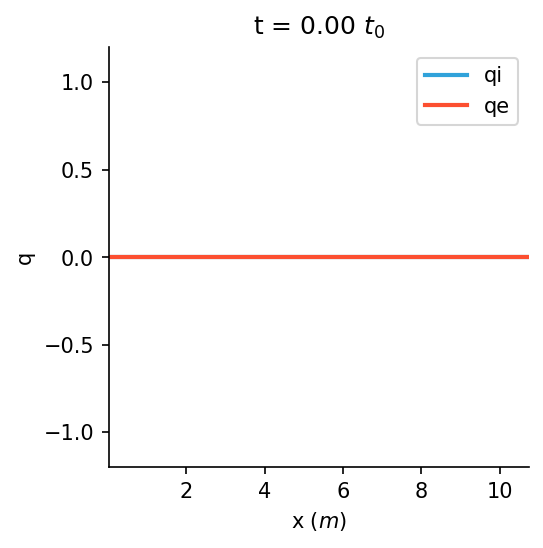
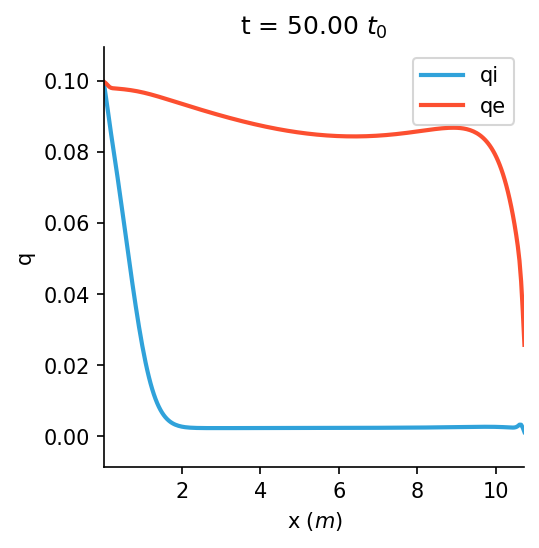
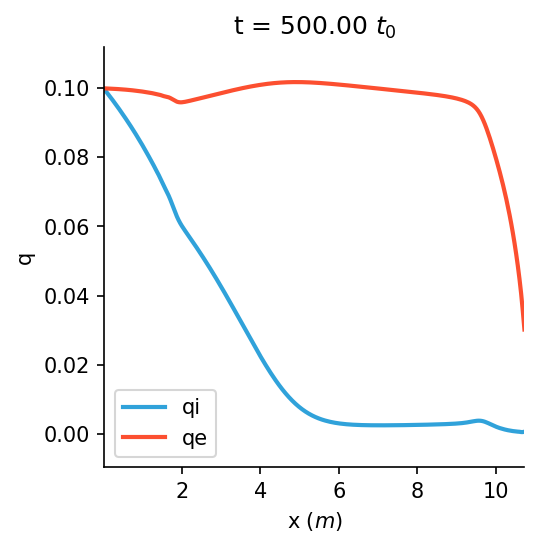
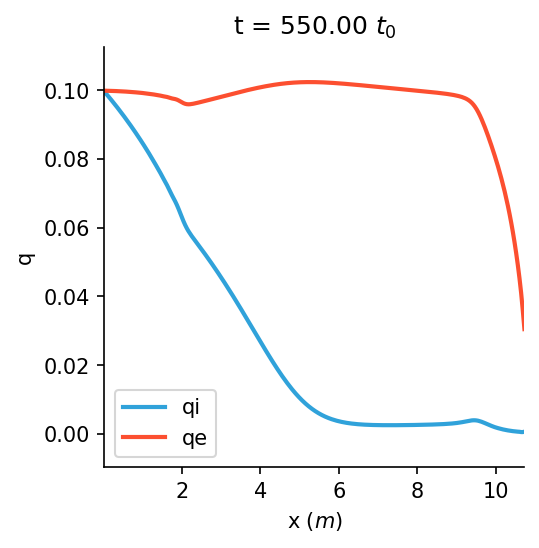
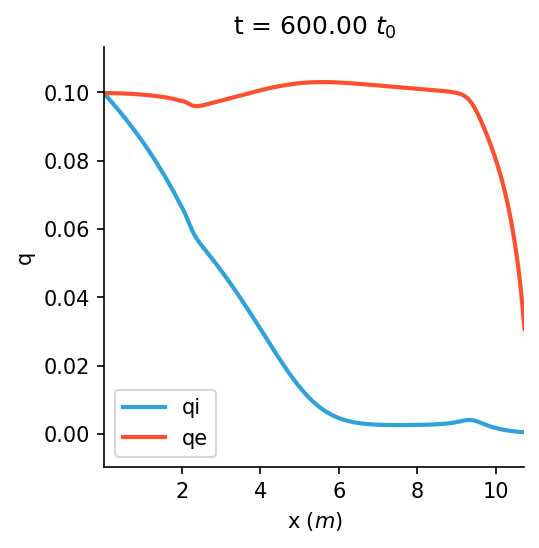
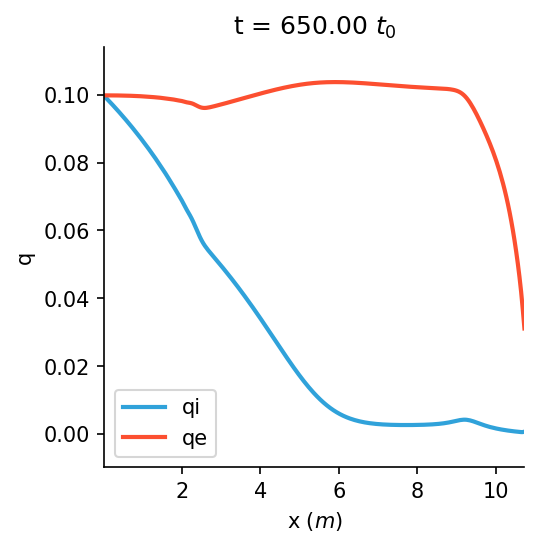
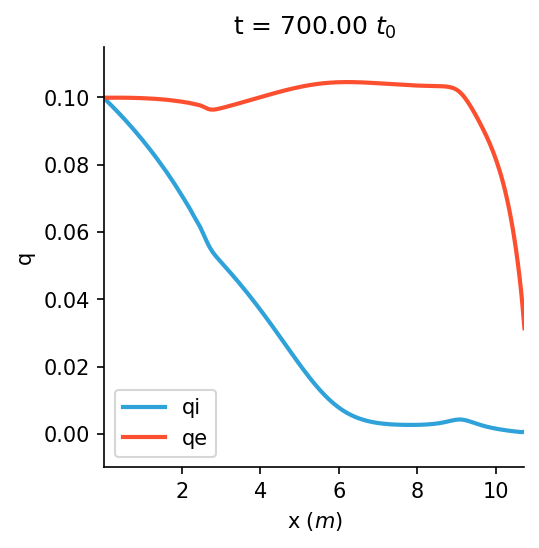
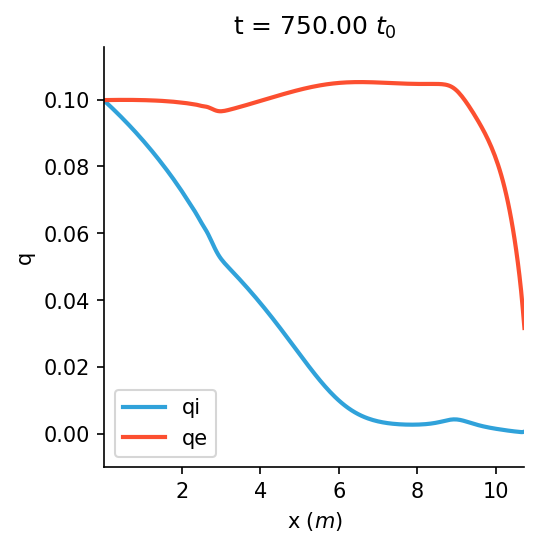
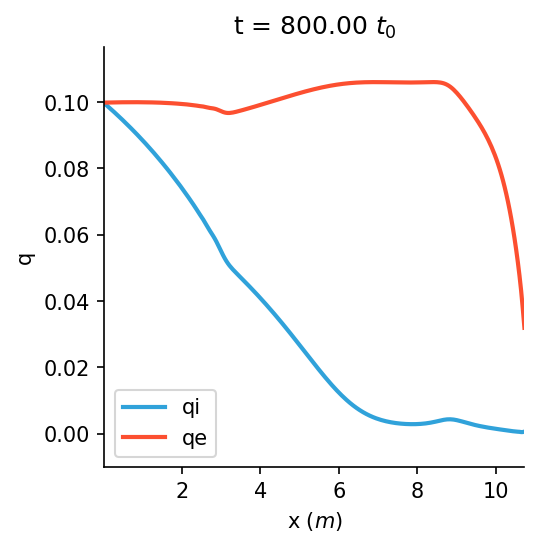
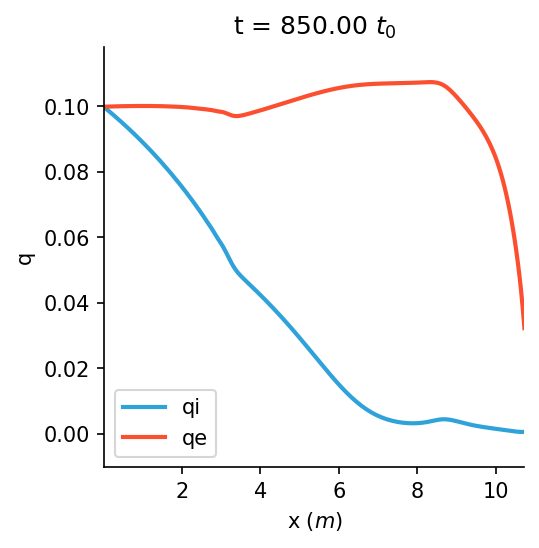
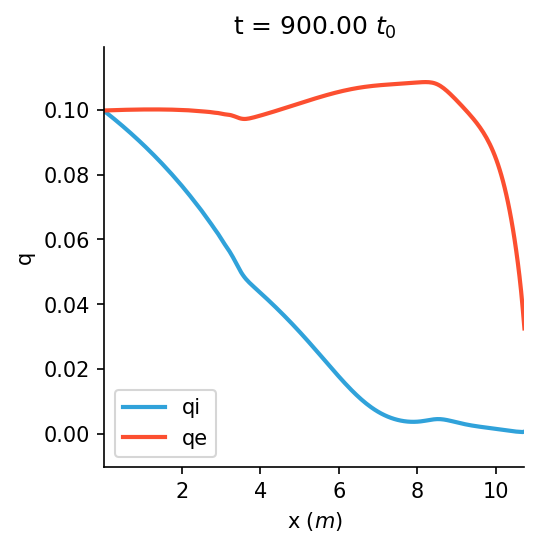
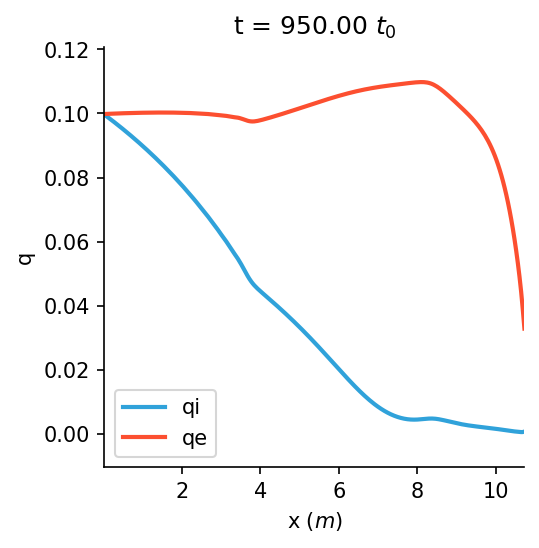
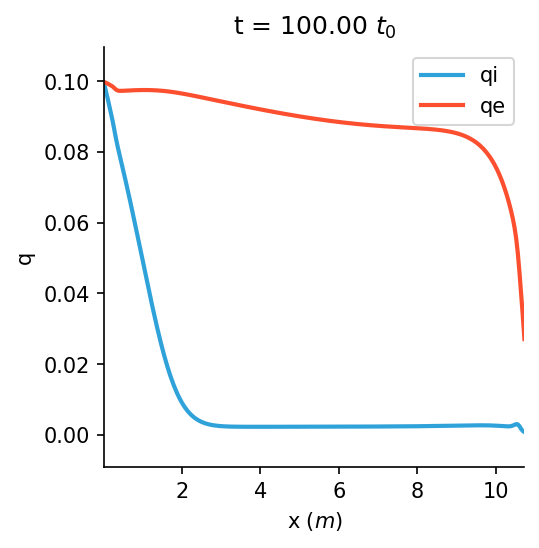
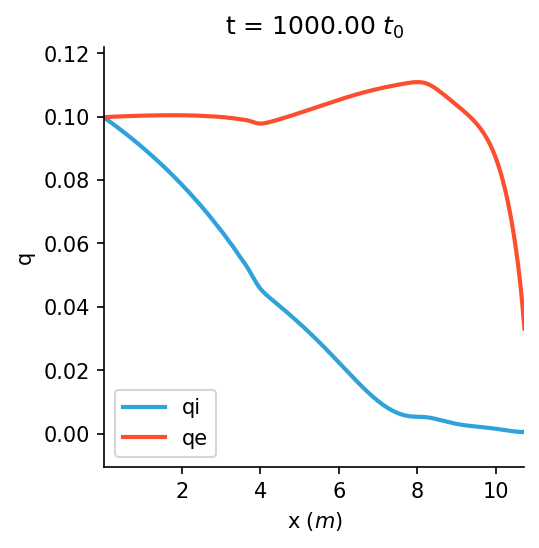
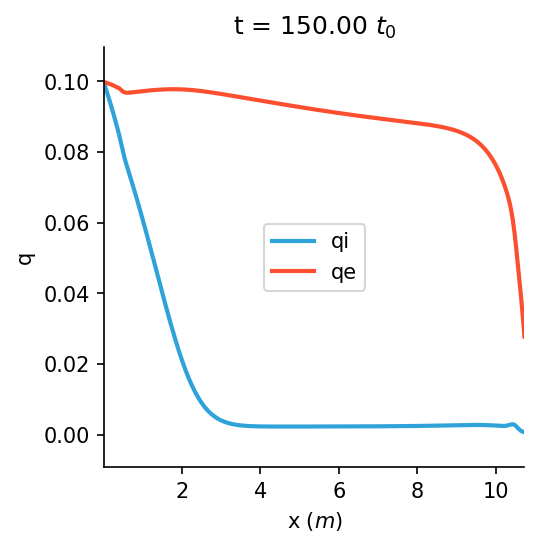
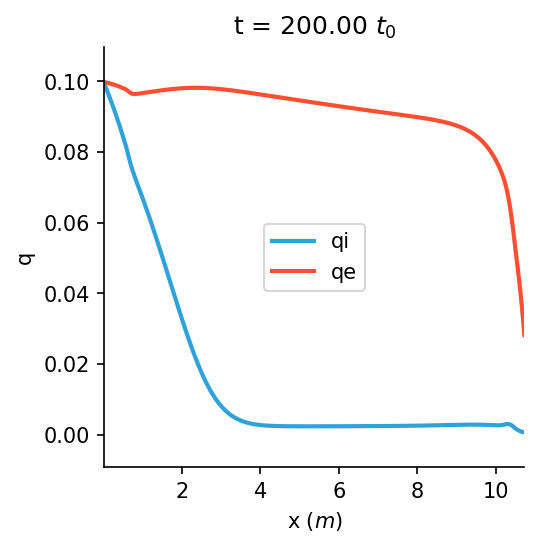
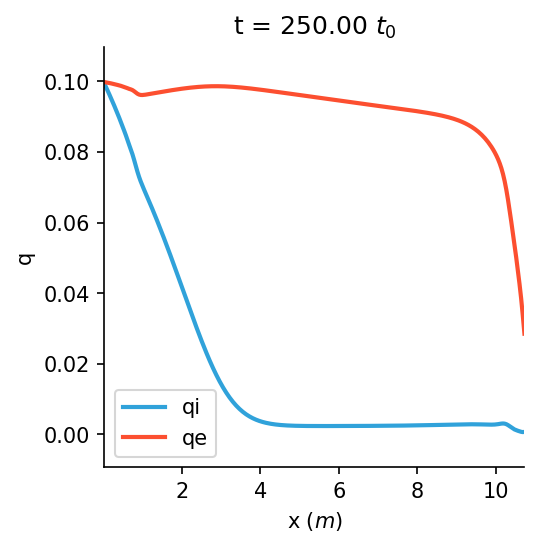
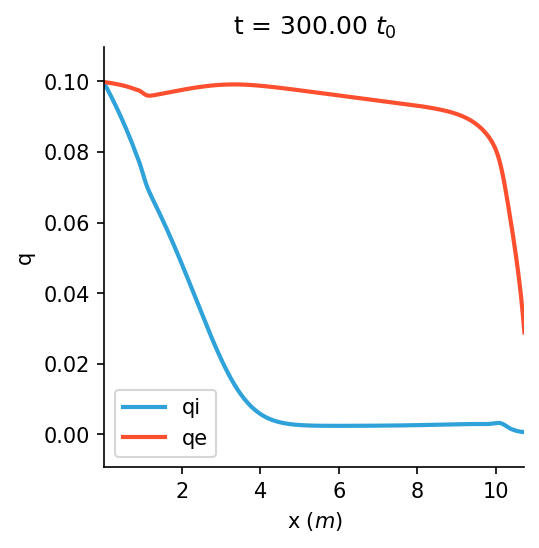
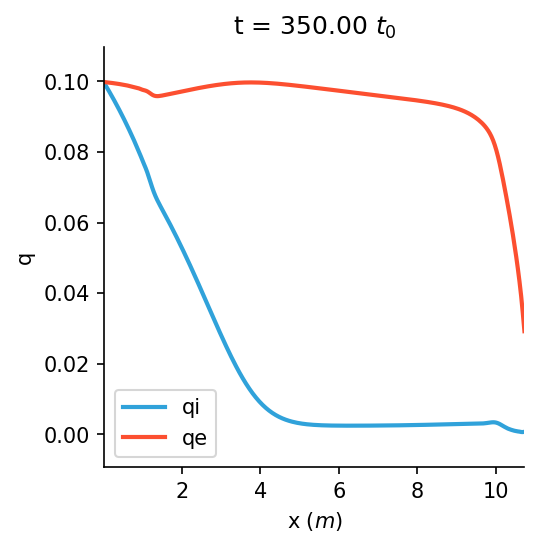
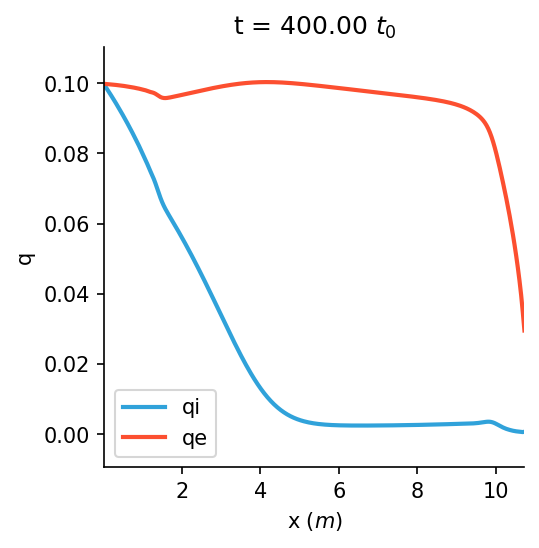
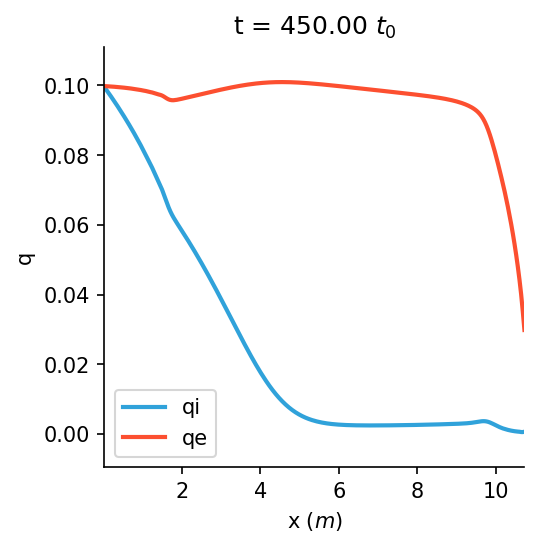
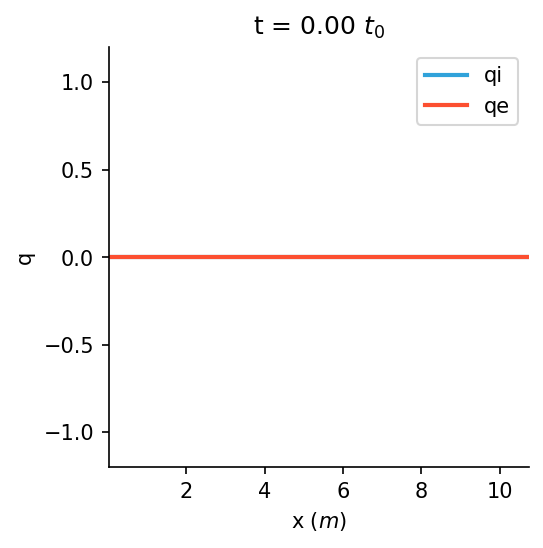

In [48]:
dashboard.fluidMultiComparison(["qi", "qe"]).opts(xlabel="x ("+loadedData.coords["x"].units+")", ylabel="q")


:HoloMap   [time]
   :Overlay
      .Curve.Ti :Curve   [x]   (Ti)
      .Curve.Te :Curve   [x]   (Te)
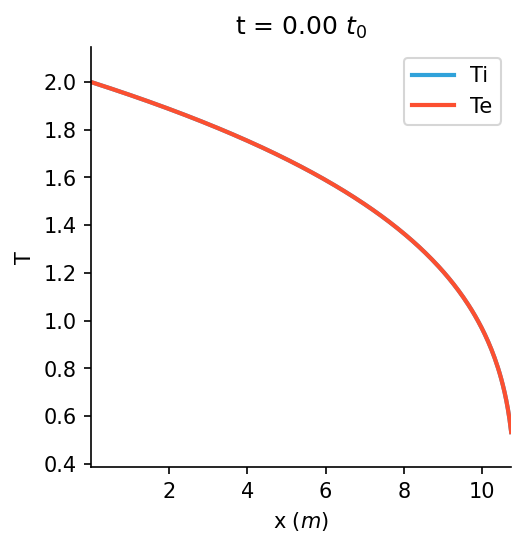
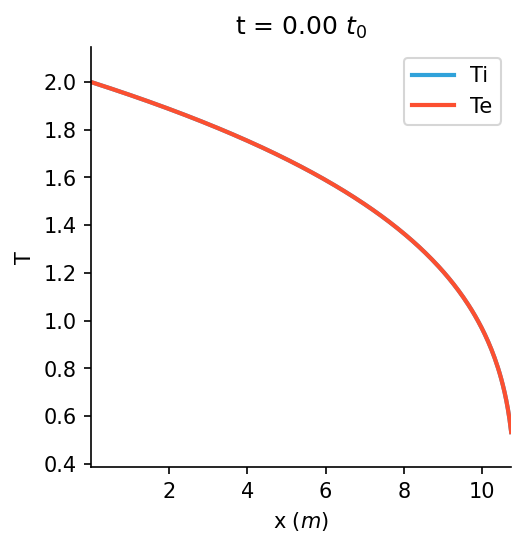
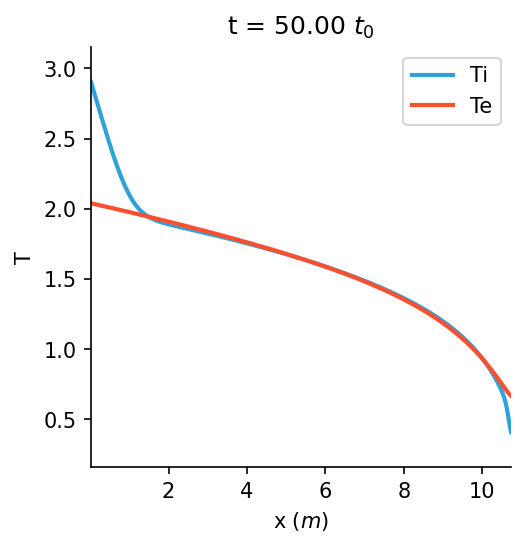
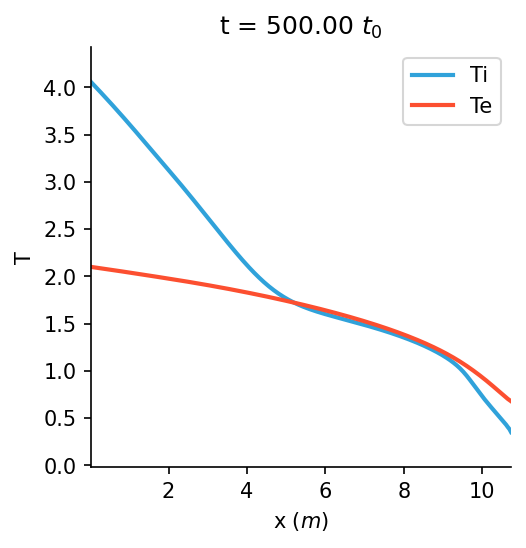
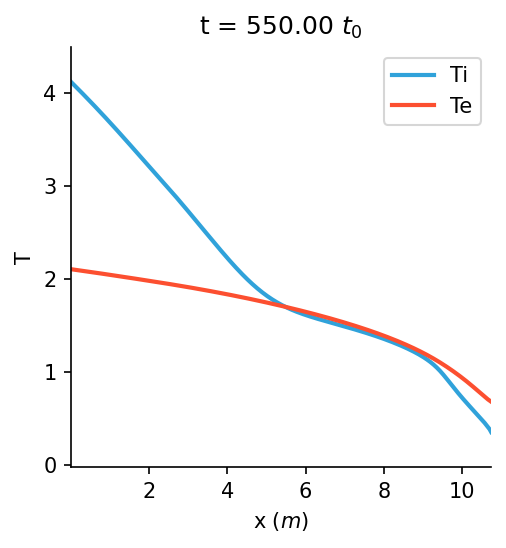
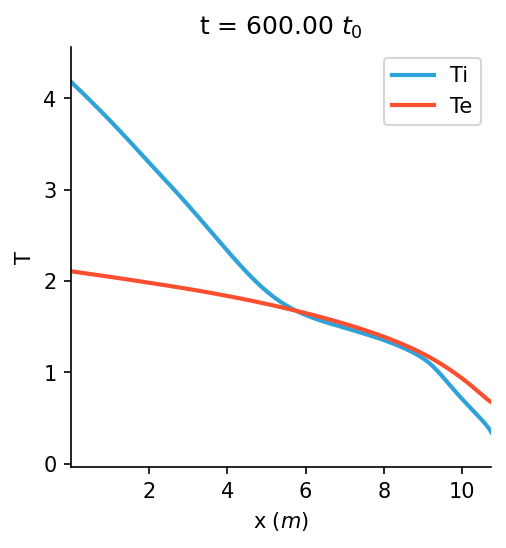
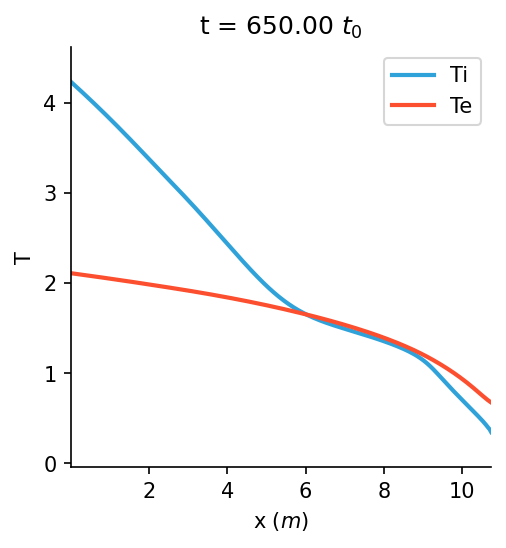
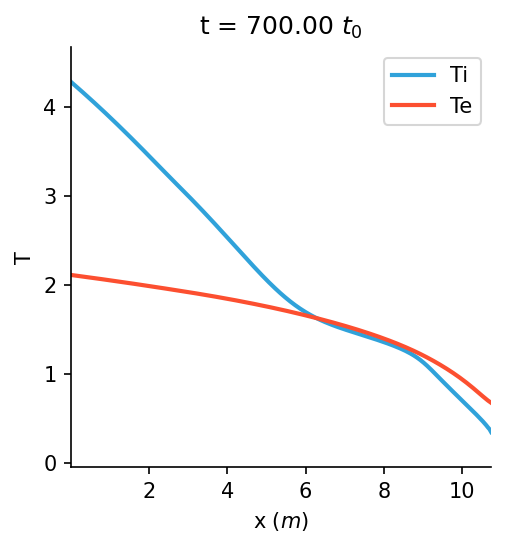
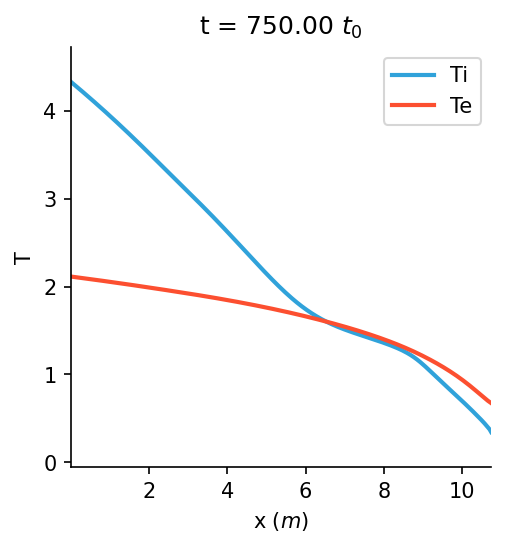
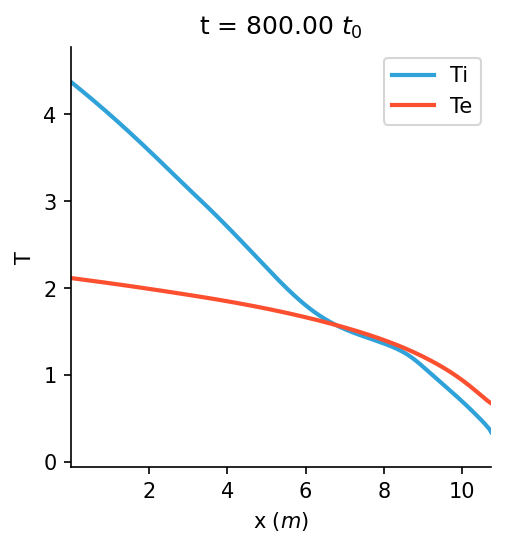
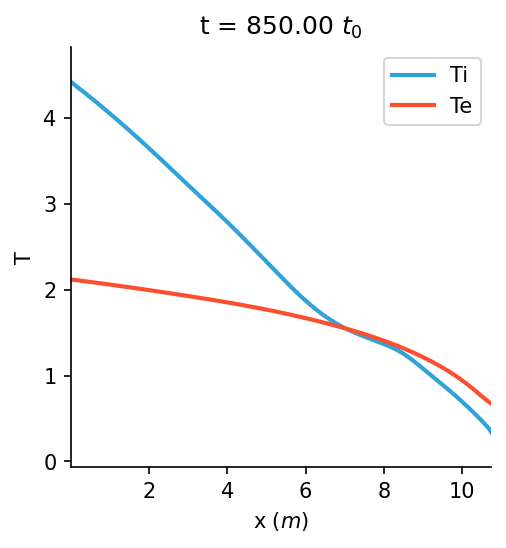
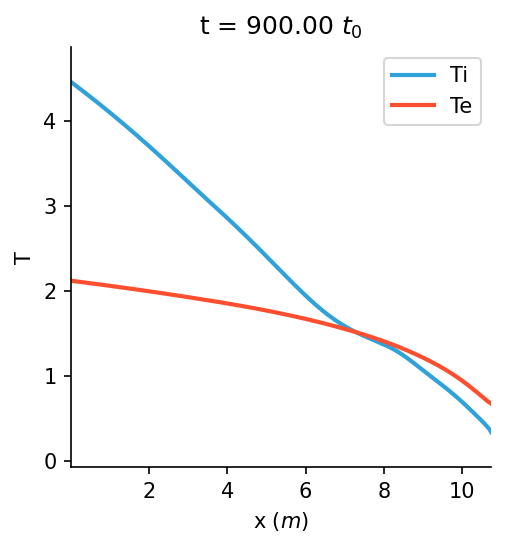
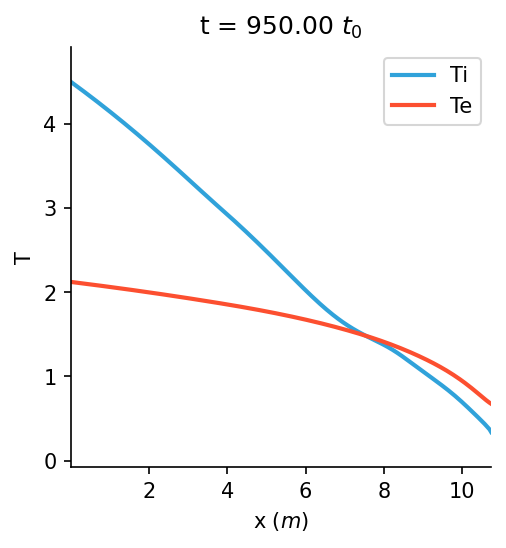
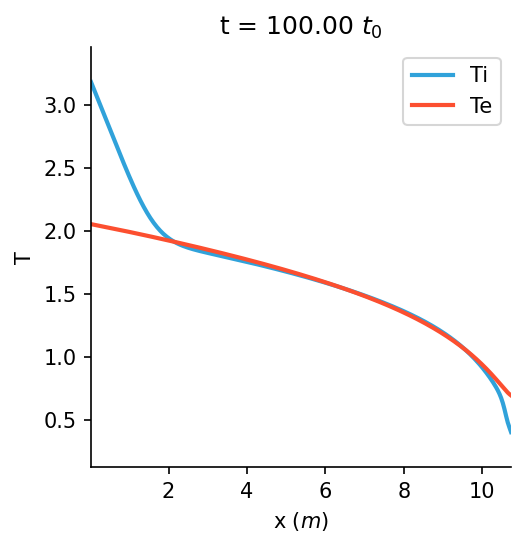
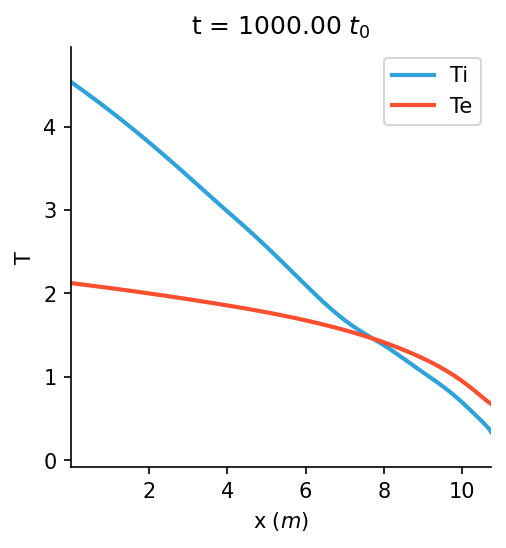
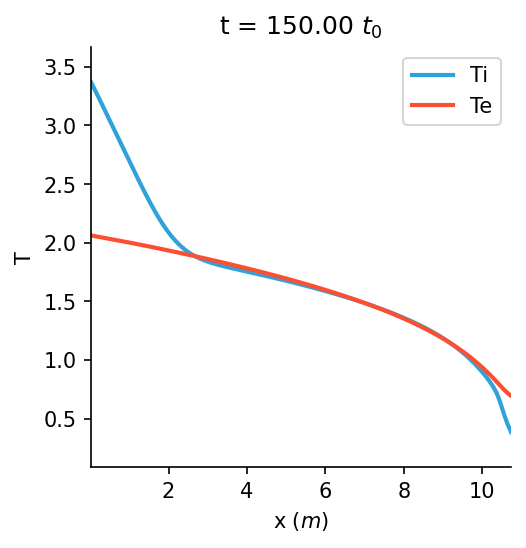
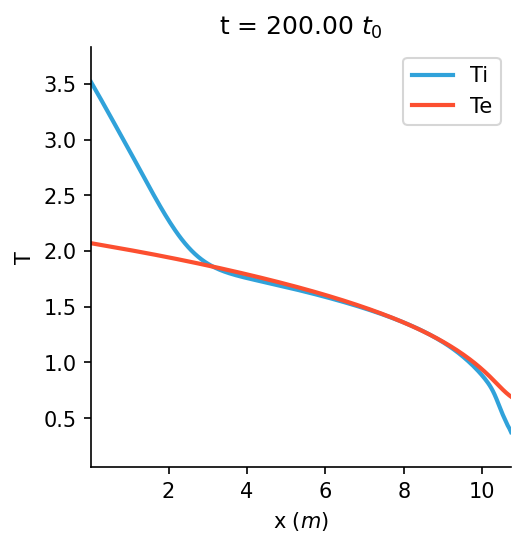
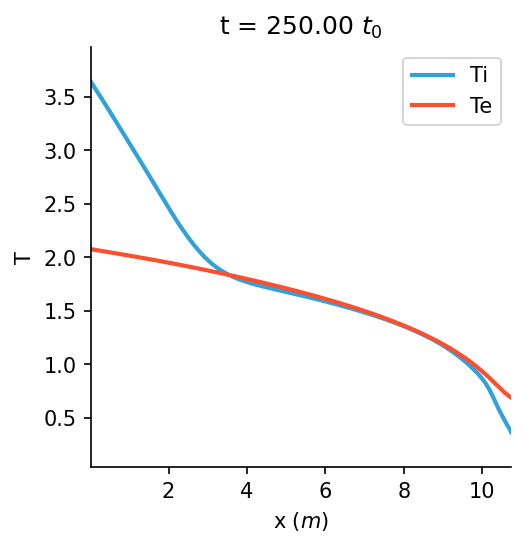
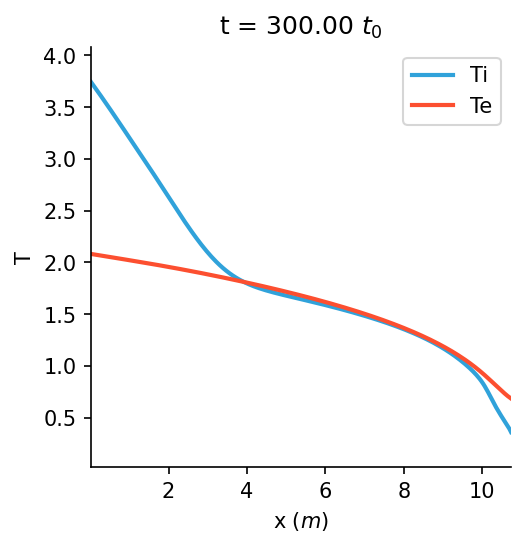
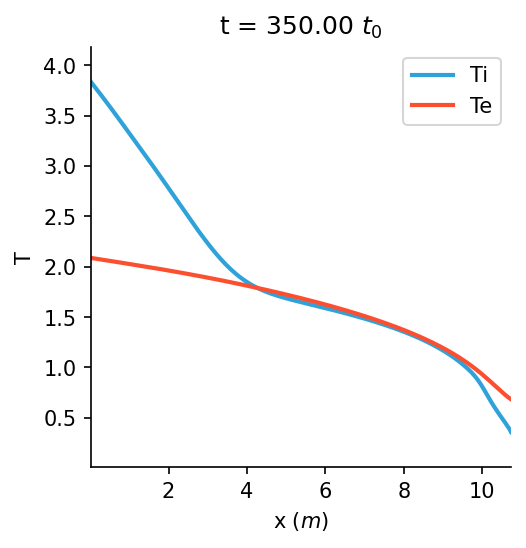
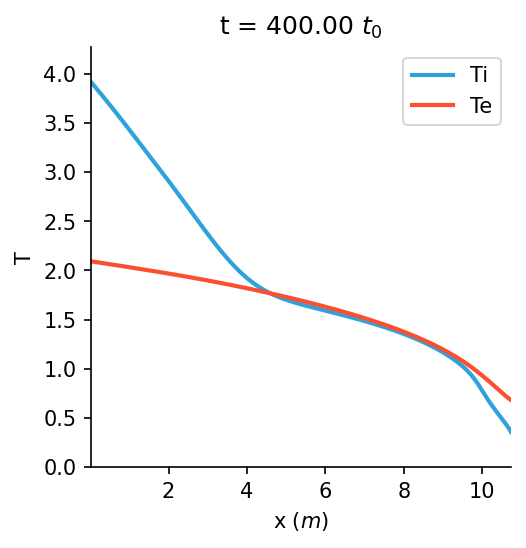
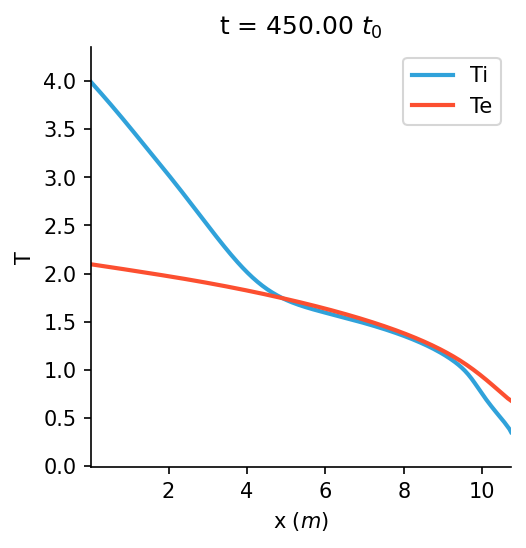

In [49]:
dashboard.fluidMultiComparison(["Ti", "Te"]).opts(xlabel="x ("+loadedData.coords["x"].units+")", ylabel="T")
